# Data and other imports

### imports

In [1]:
import pandas as pd
import math
import numpy as np
from math import e
import random
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

# for drawing the decision tree
from graphviz import Digraph

from IPython.display import display

# decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Boosting algorithms
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor

# model building
from sklearn.model_selection import GridSearchCV

# model evaluate
from sklearn.metrics import accuracy_score, mean_squared_error

from time import perf_counter

# set seed for reproducible results
RSEED = 10

### data

In [2]:
df = pd.read_csv('data.csv')

train = df.iloc[0:8040]
validation = df.iloc[8040:10050]
test = df.iloc[10050:12563]

#### Constants

In [3]:
labelName = 'area_type'

labelNumericName = 'price in rupees'

labels = ['availability','bedrooms','total_sqft','bath','balcony','ranked','price in rupees', 'area_type']

labels_cls = ['availability','bedrooms','total_sqft','bath','balcony','ranked','price in rupees']
labels_rgr = ['area_type','availability','bedrooms','total_sqft','bath','balcony','ranked']

labelIndex = df.columns.get_loc(labelName)

labelNumericIndex = df.columns.get_loc(labelNumericName)

cls_x = 'B' 
cls_y = 'P'

# Decision Trees Definition

## Abstract Structures Definition

In [4]:
class DecisionNode:
    """
    Abstract Decision Node Definition
    """
    cnt = 0
    def __init__(self, data: pd.DataFrame, left=None, right=None, depth:int=0):
        """
        Abstract Decision Node Constructor
        Args:
            data (pd.DataFrame): the node data.
            left (DecisionNode, optional): the left child node. Defaults to None.
            right (DecisionNode, optional): the right child node. Defaults to None.
            depth (int, optional): The depth of the node. Defaults to 0.
        """
        
        self.left = left
        self.right = right
        self.data = data.values
        self.data_labels = data.columns.values
        self.depth = depth
        self.featureName = ""
        self.featureIndex = 0
        self.featureVal = 0
        self.samples = len(data)
        
        # for visualization purposes
        self.id = str(DecisionNode.cnt)
        DecisionNode.cnt += 1
        
    def _bestSplit(self):
        """
        Get the best split of the decision node.
            This method is expanded later in the child classes
        """
        pass

In [5]:
class DecisionTree:
    """
    Decision tree abstract definition
    """
    def __init__(self, maxDepth: int, minSample: int):
        """
        Decision Tree constructor

        Args:
            maxDepth (int): the max depth of the decision tree
            minSample (int): the least samples in a node allowed to be split
        """
        
        self.root : DecisionNode = None
        self.maxDepth = maxDepth
        self.minSample = minSample
        
        # for visualization purposes
        self.graph = Digraph(format="png", node_attr={"shape":"rectangle", "fontsize":"8"})

   
    def _can_split(self, node: DecisionNode):
        """
        Determine if the given node can be split

        Args:
            node (DecisionNode): the node to split

        Returns:
            bool: can we split the node?
        """
        
        if node is None:
            return False
        if (self.maxDepth > node.depth) and (self.minSample <= len(node.data)):
            return True
        return False
             
    
    def _split(self, node: DecisionNode):
        """
        Split the node on the most fitting axis
        
        Args:
            node (DecisionNode): the node to split
        """

        # perform node calibration
        node._bestSplit()

        # If the feature is categorial
        if len(np.unique(node.data[:,node.featureIndex]))<=2:
            dfB = node.data[node.data[:,node.featureIndex] == node.featureVal]
            dfA = node.data[node.data[:,node.featureIndex] != node.featureVal]
        
        # Else, if the feature to split of this node is numeric
        else:
            dfA = node.data[node.data[:,node.featureIndex] >= node.featureVal]
            dfB = node.data[node.data[:,node.featureIndex] < node.featureVal]
        
        dfA, dfB = pd.DataFrame(dfA, columns=node.data_labels), pd.DataFrame(dfB,columns=node.data_labels)
        
        return dfA, dfB
    
    
    def fit(self):
        """
        Fit the model to make a Decision Maker
        """
        
        self._fit(self.root)
        self.__connect_graph(self.root)
    
    
    def _fit(self, node: DecisionNode):
        """
        Recursive fitting function for Decision Maker.
            The expanded functionality is to be found in the children classes.
        Args:
            node (DecisionNode): the root of the decition maker
        """
        
        self._split(node)
        self._fit(node.left)
        self._fit(node.right)
    
    
    def __connect_graph(self,node: DecisionNode):
        """Recursively connect the graph of the Decision Maker
        
        Args:
            node (DecisionNode): The root of the decision maker
        """
        
        if node is None:
            return
        
        if node.left is not None:
            self.graph.edge(node.id, node.left.id)
            self.__connect_graph(node.left)
        
        if node.right is not None:
            self.graph.edge(node.id, node.right.id)
            self.__connect_graph(node.right)
        
    
    def predict(self,samp):
        """
        Predict the samp value based on he decision tree

        Args:
            samp (list): list of parameters

        Returns:
            any: the prediction
        """
        
        return self._predict(self.root,samp)
    
    
    def _predict(self, node: DecisionNode, samp):
        """
        Recursive prediction method
            Is expanded in the children classes

        Args:
            node (DecisionNode): the root
            samp (list): list of parameters

        Returns:
            any: the prediction
        """
        
        # If the feature is categorial
        if len(np.unique(node.data[:,node.featureIndex]))==2:
            if samp[node.featureIndex] == node.featureVal:
                return self._predict(node.left, samp)
            else:
                return self._predict(node.right, samp)
        # Else, if the feature is numeric
        else:
            if samp[node.featureName] >= node.featureVal:
                return self._predict(node.right, samp)
            else:
                return self._predict(node.left, samp)
    
    
    def display(self,in_console=True):
        """
        Display the classifier

        Args:
            in_console (bool, optional): Display right in the console. Defaults to True.
        """
        
        if in_console:
            display(self.graph)
        else:
            self.graph.view("decisionTree.dot")

## Classifier section 

### Classification Node Definition

In [6]:
class ClassifierNode(DecisionNode):
    """
    Classifier Node Definition

    Args:
        DecisionNode : The parent class
    """
    def __init__(self,data:pd.DataFrame, left=None, right=None, depth:int=0):
        """
        Classifier Node Constructor
        
        Args:
            data (DataFrame): the node data.
            left (ClassifierNode, optional): the left child node. Defaults to None.
            right (ClassifierNode, optional): the right child node. Defaults to None.
            depth (int, optional): The depth of the node. Defaults to 0.
        """
        
        super().__init__(data, left, right, depth)
        
        self.gini = 1 # uncalibrated gini value
        self.predictedClass = ""
    
    
    def giniScore(self):
        """
        Calculate the gini score of the current node

        Returns:
            float: the gini score
        """
        
        totalSamples = len(self.data)
        classA = self.count_class_num(cls_x)
        pA = classA/totalSamples
        if totalSamples==0:
            return 1 
        return 2*pA(1-pA)
    
    
    def count_class_num(self,className):
        """
        Count the number of samples of a certain class in the current node

        Args:
            className (str): the class name

        Returns:
            int: the number of occurrences of the class
        """
        
        try:
            return len(self.data[self.data[:,labelIndex] == className])
        
        #if there are no samples from the requested class(a pure split)
        except Exception:
            return 0


    # threshold is used for numeric feature         
    def calc_gini_impurity(self,feature_index:int, threshold=None):
        """
        Calculate the gini impurity factor

        Args:
            feature_index (int): the feature index we calcu
            threshhold (int | float): the axis we divide the data with

        Returns:
            float: the gini impurity factor
        """
        
        # If the feature index is categorial
        if threshold is None:
            values = np.unique(self.data[:,feature_index])
            r = self.data[self.data[:,feature_index] == values[0]]
            l = self.data[self.data[:,feature_index] == values[1]]
            
        # Else, if the feature index is numerical
        else:
            r = self.data[self.data[:,feature_index] >= threshold]
            l = self.data[self.data[:,feature_index] < threshold]
            
        lP = len(l[l[:,labelIndex] == cls_y])
        rP = len(r[r[:,labelIndex] == cls_y])

        # if there is a clean split (all samples in one child node)
        if len(r)==0 or len(l)==0:
            return float('inf')
        
        p1 = lP/len(l)
        p2 = rP/len(r)

        # calculate the gini impurity
        
        giniL = 2*p1*(1-p1)
        giniR = 2*p2*(1-p2)

        total = len(r) + len(l)
        
        totalGini = (len(r)*giniR + len(l)*giniL)/total
        
        return totalGini
    
    
    
    def calc_gini_numeric_feature(self, feature_index: int):
        """
        Calculate the gini impurity for numeric feature

        Args:
            feature_index (int): the numeric feature index

        Returns:
            float: the gini impurity factor
        """

        # Sort the values of the new dataframe, increasing by the values of the nomericFeature column
        self.data[self.data[:, feature_index].argsort()]

        best_gini, best_threshold = 1, float('inf')

        # run on any adjacent values and find the best split axis
        for i in range(0, len(self.data)-1) :
            threshold = (self.data[i][feature_index]+self.data[i+1][feature_index])/2
            gini = self.calc_gini_impurity(feature_index, threshold)
            if gini < best_gini:
                best_gini = gini
                best_threshold = threshold

        return best_gini, best_threshold
     
    
    def _bestSplit(self):
        """
        Perform a node calibration, 
            and find the best split axis for the current node
        """
        
        min_gini = 1
        
        for i in range (len(self.data_labels)):
        
            # if self.data_labels[i]!=labelName :
            if i!=0 and self.data_labels[i]!=labelName :
                
                #in case that the feature is categorial
                if len(np.unique(self.data[:,i]))==2 : 
                    self.featureVal = 0
                    gini = self.calc_gini_impurity (i, None)
                    if gini < min_gini:
                        min_gini = gini
                        self.featureName = self.data_labels[i]
                        self.featureIndex = i
                        self.featureVal = 1
                        self.gini = gini
                        
                #in case that the feature is numeric        
                else :
                    numricGini, threshold = self.calc_gini_numeric_feature(i)
                    if numricGini < min_gini:
                        min_gini = numricGini
                        self.featureName = self.data_labels[i]
                        self.featureIndex = i
                        self.featureVal = threshold
                        self.gini = numricGini
        
    
    def make_leaf(self):
        """
        Make a leaf out of current Node
        """
        pA, pB = self.count_class_num(cls_x), self.count_class_num(cls_y)
        self.predictedClass = cls_x if pA > pB else cls_y
        
    
    def __str__(self):
        """
        String Representation

        Returns:
            str: the representation
        """
        return f"Predicting: {self.predictedClass}" if self.predictedClass!="" else f"Spliting on\n{self.featureName}={self.featureVal}"


### Classifier Definition

In [7]:
class Classifier(DecisionTree):
    """
    A Classification Tree Definition
    
    Args:
        DecisionTree: the parent class
    """
    def __init__(self, data, maxDepth, minSample):
        """
        Classifier Constructor

        Args:
            data (pd.DataFrame): the data of the classifier
            maxDepth (int): the max depth of the classifier
            minSample (int): the minimum samples in a node in order to split
        """
        
        super().__init__(maxDepth, minSample)
        
        self.root = ClassifierNode(data)
            
    def _split(self, node: ClassifierNode):
        """
        Expansion on the _split(node) method of DecisionTree.
            Splits the node whether it is possible.
        
        Args:
            node (ClassifierNode): the node to split
        """
        
        dfA, dfB = super()._split(node)

        if len(dfA) > 0 and len(dfB) > 0:
            node.right = ClassifierNode(data=dfA,depth=node.depth+1)
            node.left = ClassifierNode(data=dfB,depth=node.depth+1)
        else:
            node.make_leaf()
            
        
    def _fit(self, node: ClassifierNode):
        """Expansion on the _fit(node) method of DecisionTree 
            to build the classifier

        Args:
            node (ClassifierNode): the Classifier node
        """
        
        if self._can_split(node) and node.gini != 0:
            super()._fit(node)

        else:
            if node is not None:
                classA = node.count_class_num(cls_x)
                if not isinstance(classA, int) and not isinstance(classA, np.int64):
                    classA = len(classA)
                classB = len(node.data)-classA
                if classA > classB:
                    node.predictedClass = cls_x
                else:
                    node.predictedClass = cls_y
        if node is not None:
            self.graph.node(node.id, node.__str__())
    
    
    def _predict(self, node: ClassifierNode ,samp):
        """
        Predict the samp value

        Args:
            node (ClassifierNode): the root
            samp (list): parameters list

        Returns:
            str: the predicted class
        """
        
        if node.right is None and node.left is None :
            return node.predictedClass

        return super()._predict(node, samp)


    def evaluate(self, data: pd.DataFrame):
        """
        Evaluate the Classifier

        Args:
            data (DataFrame): the data to be evaluated

        Returns:
            dict: with accuracy, sensitivity, specificity, precision
        """

        TP = 0 # TRUE POSITIVE
        TN = 0 # TRUE NEGATIVE
        FP = 0 # FALSE POSITIVE 
        FN = 0 # FALSE NEGATIVE
        # y_pred = [
        #     self.predict(data.iloc[i])
        #     for i in range(0,len(data))
        # ]
        for i in range(len(data)):
            s = data.iloc[i]
            predicted_value = self.predict(s)
            
            if s[labelName] == predicted_value:
                if predicted_value == cls_x:
                    TP+=1 
                else:
                    TN+=1 
            else:
                if predicted_value == cls_x:
                    FP+=1 
                else:
                    FN+=1 

        metrics = {}
        metrics["accuracy"] = (TP+TN)/(TP+TN+FP+FN)
        metrics["sensitivity"] = TP/(TP+FN)
        metrics["specificity"] = TN/(TN+FP)
        metrics["precision"] = TP/(TP+FP)

        return metrics


### Model evaluation

#### DIY model evaluation

##### Grid Search

In [10]:
from itertools import product
cls_args = {
    "maxDepth" : [3, 6],
    "minSpit" : [4, 17]
}
arg_list = list(cls_args.values())
combinations = list(product(arg_list[0], arg_list[1]))
best_cls = None
best_acc = 0
cls_diy_runtime = 0
for i in trange(0,len(combinations)):
    cls = Classifier(train,combinations[i][0], combinations[i][1])
    start_cls_diy = perf_counter()
    cls.fit()
    cls_diy_runtime_ = perf_counter() - start_cls_diy
    acc = cls.evaluate(validation)['accuracy']
    if acc > best_acc:
        best_cls = cls
        best_acc = acc
        cls_diy_runtime = cls_diy_runtime_

  0%|          | 0/4 [00:00<?, ?it/s]

##### evaluation

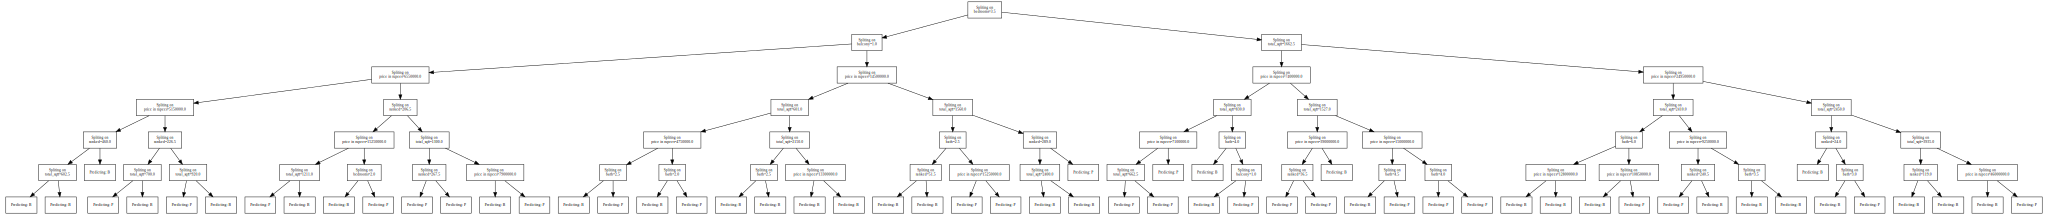

In [11]:
best_cls.display()

In [ ]:
diy_cls_metrics = best_cls.evaluate(test)
cls_acc_diy = diy_cls_metrics['accuracy']


diy_cls_metrics['runtime'] = cls_diy_runtime
diy_cls_metrics = pd.DataFrame.from_dict(diy_cls_metrics, orient='index').rename(columns={0 : "Values"})

display(diy_cls_metrics)

#### Comparing to sklearn results

In [ ]:
X_cls_train, X_cls_valid, X_cls_test = train[labels_cls], validation[labels_cls], test[labels_cls]
y_cls_train, y_cls_valid, y_cls_test = train[labelName], validation[labelName], test[labelName]

In [ ]:
skl_cls = DecisionTreeClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [7, 14],
    'min_samples_split': [2, 17],
    'min_samples_leaf': [2, 8]
}

# define grid search
grid_search = GridSearchCV(estimator=skl_cls, param_grid=parameters_grid, cv=10)

In [ ]:
start_cls_skl = perf_counter()
grid_search.fit(X_cls_train, y_cls_train)
cls_skl_runtime = perf_counter() - start_cls_skl

# get best estimator
best = grid_search.best_estimator_

In [ ]:
plt.figure(figsize=(15, 15))
fig = tree.plot_tree(best, feature_names=X_cls_train.columns, class_names=['0', '1'], filled=True)

In [ ]:
y_pred = best.predict(X_cls_test)

cls_acc_skl = round(accuracy_score(y_cls_test, y_pred), 3)

In [ ]:
cls_acc = {
    "sklearn accuracy" : cls_acc_skl,
    "diy accuracy" : cls_acc_diy,
    "accuracy ratio" : min(cls_acc_diy, cls_acc_skl)/max(cls_acc_diy, cls_acc_skl)
}
cls_times = {
    "sklearn runtime" : cls_skl_runtime,
    "diy runtime" : cls_diy_runtime,
    "runtime ratio" : min(cls_skl_runtime, cls_diy_runtime)/max(cls_skl_runtime, cls_diy_runtime)
}

cls_acc = pd.DataFrame.from_dict(cls_acc, orient='index').rename(columns={0 : 'Values'})
cls_times = pd.DataFrame.from_dict(cls_times, orient='index').rename(columns={0 : 'Values'})

print("accuracy comparison:")
display(cls_acc)
print("runtime comparison:")
display(cls_times)

## Regressor section

### Regression Node Definition

In [ ]:
class ReggressionNode(DecisionNode):
    """
    Regression Node Definition

    Args:
        DecisionNode : The parent class
    """
    def __init__(self,data:pd.DataFrame, left=None, right=None, depth:int=0):
        """
        Regression Node Constructor
        
        Args:
            data (DataFrame): the node data.
            left (ClassifierNode, optional): the left child node. Defaults to None.
            right (ClassifierNode, optional): the right child node. Defaults to None.
            depth (int, optional): The depth of the node. Defaults to 0.
        """
        
        super().__init__(data, left, right, depth)
        
        self.ssr = 0 # Uncalibrated ssr value
        
        self.predictedVal = np.mean(self.data[:, labelNumericIndex])


    # This function choose the best avg to split by choosing avg that gives the lowest ssr
    def calc_ssr_to_feature (self, feature_index:int):
        """
        Calculate the ssr for a feature 
        Args:
            feature_index (int): the feature index

        Returns:
            float: the calculated ssr value
        """


        # If the feature is categorial
        if len(np.unique(self.data[:,feature_index]))<=2:
            
            # if only one category, don't split
            if len(np.unique(self.data[:,feature_index]))<2:
                min_ssr = float('inf')
                best_avarage = float('inf')
            
            else:
                values = np.unique(self.data[:,feature_index]) # return array with thw two optional values
                class_right = self.data[self.data[:,feature_index] == values[0]]
                class_left = self.data[self.data[:,feature_index] == values[1]]
                right_ssr = self.calc_ssr(class_right)
                left_ssr = self.calc_ssr(class_left)
                feature_ssr = right_ssr + left_ssr
                min_ssr = feature_ssr

                best_avarage = 0
        else:
            
            # Sort the values of the new dataframe by the feature index column
            self.data[self.data[:,feature_index].argsort()]

            min_ssr = float('inf')
            best_avarage = float('inf')

            for i in range(0, len(self.data)-1) :
                
                avarage = (self.data[i][feature_index]+self.data[i+1][feature_index])/2
                class_right = self.data[self.data[:,feature_index] >= avarage]
                class_left = self.data[self.data[:,feature_index] < avarage]
                right_ssr = self.calc_ssr(class_right)
                left_ssr = self.calc_ssr(class_left)
                feature_ssr = right_ssr + left_ssr
                
                if feature_ssr < min_ssr:
                    min_ssr = feature_ssr
                    best_avarage = avarage

        return min_ssr, best_avarage

    def calc_ssr(self, data: np.ndarray):
        """
        Calculate the ssr of the current data

        Args:
            data (np.ndarray): the data

        Returns:
            float: the ssr value
        """

        label_values = data[ : , labelNumericIndex]

        avg = []
        
        [
            avg.append(np.mean(label_values) if len(label_values) > 0 else 0)
        ]
        
        ssr = np.sum((label_values - avg)**2)
        
        return ssr

    def _bestSplit(self):
        """
        Perform a node calibration, 
            and find the best split axis for the current node
        """

        min_ssr = float('inf')

        for i in range (len(self.data_labels)):

            if i!=0 and self.data_labels[i]!=labelNumericName :

                ssr_score, best_avg = self.calc_ssr_to_feature(i)

                if ssr_score < min_ssr:
                    min_ssr = ssr_score
                    self.ssr = ssr_score
                    self.featureName = self.data_labels[i]
                    self.featureIndex = i
                    self.featureVal = best_avg
    
    def __str__(self):
        return f"Predicting: {round(self.predictedVal,3)}" if self.left is None and self.right is None else f"Spliting on\n{self.featureName}={self.featureVal}"

### Regressor Definition

In [ ]:
class Regressor(DecisionTree):
    """
    A Regression Tree Definition
    
    Args:
        DecisionTree: the parent class
    """
    
    def __init__(self, data:pd.DataFrame, maxDepth, minSample):
        """
        Regressor Constructor

        Args:
            data (pd.DataFrame): the data of the regressor
            maxDepth (int): the max depth of the regressor
            minSample (int): the minimum samples in a node in order to split
        """
        
        super().__init__(maxDepth, minSample)
        
        self.root = ReggressionNode(data)

    
    def _split(self, node: ReggressionNode):
        """Expansion on the _split(node) method of DecisionTree.
            Splits the node whether it is possible.
        
        Args:
            node (ReggressionNode): the node to split
        """

        dfA, dfB = super()._split(node)
        if len(dfA) > 0 and len(dfB) > 0: # in case we split the data correctly
            
            node.right = ReggressionNode(dfA,None,None, node.depth+1)
            node.left = ReggressionNode(dfB, None,None, node.depth+1)

    
    def _fit(self, node: ReggressionNode):
        """Expansion on the _fit(node) method of DecisionTree 
            to build the regressor

        Args:
            node (ReggressionNode): the Classifier node
        """
        
        if self._can_split(node):
            super()._fit(node)
        if node is not None:
            self.graph.node(node.id, node.__str__())


    def _predict(self, node: ReggressionNode ,samp):
        """
        Predict the samp value

        Args:
            node (ReggressionNode): the root
            samp (list): parameters list

        Returns:
            float: the predicted value
        """

        if (node.right is None) and (node.left is None) :

            return node.predictedVal

        return super()._predict(node, samp)

    
    def evaluate(self, data:pd.DataFrame):
        """
        Evaluate the Regressor

        Args:
            data (DataFrame): the data to be evaluated

        Returns:
            float: the MSE score
        """
    # This function evaluate the Regression Tree
    # return: MSE
        y = data[labelNumericName]
        X = data[labels_rgr]
        # for i in range(len(data)):
        #     s = data.iloc[i] # s is sample
        #     predicted.append(self.predict(s))
        predicted = [
            self.predict(X.iloc[x])
            for x in range(len(X))
        ]
        return np.square(np.subtract(y,predicted)).mean()

### Model evaluation

#### DIY model evaluation

##### Grid Search

In [ ]:
from itertools import product
rgr_args = {
    "maxDepth" : [3, 5],
    "minSpit" : [4, 17]
}
arg_list = list(cls_args.values())
combinations = list(product(arg_list[0], arg_list[1]))
best_rgr : Regressor = None
best_mse = float('inf')
cls_diy_runtime = 0
for i in range(0,len(combinations)):
    rgr = Regressor(train,combinations[i][0], combinations[i][1])
    start_rgr_diy = perf_counter()
    rgr.fit()
    rgr_diy_runtime_ = perf_counter() - start_rgr_diy
    mse_ = rgr.evaluate(validation)
    if mse_ < best_mse:
        best_rgr = rgr
        best_mse = mse_
        rgr_diy_runtime = rgr_diy_runtime_

##### Evaluation

In [ ]:
best_rgr.display()

In [ ]:
diy_mse = best_rgr.evaluate(test)

#### Comparing to sklearn results

##### One hot encode

In [ ]:
PB_train, PB_valid, PB_test= pd.get_dummies(train[labelName]).drop('B', axis=1), pd.get_dummies(validation[labelName]).drop('B', axis=1), pd.get_dummies(test[labelName]).drop('B', axis=1)

PB_train.rename(columns={"P": labelName}, inplace=True),PB_valid.rename(columns={"P": labelName}, inplace=True),PB_test.rename(columns={"P": labelName}, inplace=True)

X_rgr_train, X_rgr_valid, X_rgr_test = train[labels_rgr], validation[labels_rgr], test[labels_rgr]
y_rgr_train, y_rgr_valid, y_rgr_test = train[labelNumericName], validation[labelNumericName], test[labelNumericName]

X_rgr_train, X_rgr_valid, X_rgr_test = X_rgr_train.drop(labelName, axis=1), X_rgr_valid.drop(labelName, axis=1), X_rgr_test.drop(labelName, axis=1)
X_rgr_train, X_rgr_valid, X_rgr_test = X_rgr_train.join(PB_train), X_rgr_valid.join(PB_valid), X_rgr_test.join(PB_test)

##### evaluate

In [ ]:
skl_rgr = DecisionTreeRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [7,14],
    'min_samples_split': [7,14],
    'min_samples_leaf': [2, 8]
}

# define grid search
grid_search = GridSearchCV(estimator=skl_rgr, param_grid=parameters_grid, cv=10)

In [ ]:
start_rgr_skl = perf_counter()
grid_search.fit(X_rgr_train, y_rgr_train)
rgr_skl_runtime = perf_counter() - start_rgr_skl

# get best estimator
best = grid_search.best_estimator_

In [ ]:
plt.figure(figsize=(15, 15))
fig = tree.plot_tree(best, feature_names=X_cls_train.columns, class_names=['0', '1'], filled=True)

In [ ]:
y_pred = best.predict(X_rgr_test)

skl_mse = round(mean_squared_error(y_rgr_test, y_pred), 3)

In [ ]:
from decimal import Decimal

rgr_mse = {
    "sklearn mse" : round(Decimal(skl_mse),3),
    "diy mse" : round(Decimal(diy_mse),3),
    "mse ratio" : round(Decimal(min(skl_mse, diy_mse)/max(skl_mse, diy_mse)),3)
}

rgr_times = {
    "sklearn runtime" : rgr_skl_runtime,
    "diy runtime" : rgr_diy_runtime,
    "runtime ratio" : min(rgr_skl_runtime, rgr_diy_runtime)/max(rgr_skl_runtime, rgr_diy_runtime)
}

rgr_mse = pd.DataFrame.from_dict(rgr_mse, orient='index').rename(columns={0: 'Value'})
rgr_times = pd.DataFrame.from_dict(rgr_times, orient='index').rename(columns={0 : 'Values'})

print("MSE comparison:")
display(rgr_mse)
print("runtime comparison:")
display(rgr_times)

# Adaboost Classifier Section

In [ ]:
min_samples = 5

### Stump Definition

In [ ]:
class Stump(Classifier):
    """
    Stump Definition

    Args:
        Classifier : the parent class
    """
    def __init__(self, data):
        """
        Stump Constructor

        Args:
            data (DataFrame): the data of the stump
        """
        
        super().__init__(data, 1, min_samples)
        
        super().fit()
        
        self.data = data
        self.total_err = self.calc_total_error()
        self.weight = self.calc_stump_weight()

        self.add_sample_weight_column()
        self.add_ranges_column()
        
        
    
    def calc_total_error(self):
        """
        Calculate the total error of the current stump
        
        Returns:
            float : the total error of the current stump
        """        
        
        vector_results = []
        [
            vector_results.append(self.predict(self.data.iloc[i])) 
            for i in range(0, len(self.data))
        ]
        
        prediction = {"prediction" : vector_results}
        prediction = pd.DataFrame.from_dict(prediction).rename(columns={0: "prediction"})
        
        self.data = self.data.join(prediction)

        count = len(self.data.loc[self.data[labelName] != vector_results])
        for i in range(0,len(self.data)):
            if self.data.iat[i,labelIndex] != vector_results[i]:
                count+=1
                
        sample_weight = 1/len(self.data)
        
        return count * sample_weight
    
    def add_sample_weight_column(self):
        """
        Calculate and add sample weight column to current Stump data
        """

        sample_weight = 1/len(self.data)

        sample_weight_column = []
        [
            sample_weight_column.append(sample_weight*(e ** self.weight)) 
            if self.data.at[i,'prediction'] == self.data.at[i,labelName] 
            else sample_weight_column.append(sample_weight*(e**((-1)*self.weight))) 
            for i in range(0,len(self.data))
        ]
        
        weights_sum = np.sum(sample_weight_column)

        for i in range(0, len(sample_weight_column)):
            sample_weight_column[i] = sample_weight_column[i] / weights_sum

        sample_weight = {"sample weight" : sample_weight_column}
        sample_weight = pd.DataFrame.from_dict(sample_weight_column).rename(columns={0:"sample weight"})
        
        self.data = self.data.join(sample_weight)
        
    def add_ranges_column(self):
        """
        Calculate and add ranges column to current Stump data
        """
        
        from itertools import accumulate
        ranges_column = list(accumulate(self.data['sample weight']))
        
        ranges = {"range" : ranges_column}
        ranges = pd.DataFrame.from_dict(ranges).rename(columns={0: "range"})
        
        self.data = self.data.join(ranges)
        
    def calc_stump_weight(self):
        """
        Calculate the weight of current Stump
        
        Returns:
            float: the weight of the current Stamp
        """
        if self.total_err <= 0:
            self.total_err = 0.000073 # non zero error rate
        elif self.total_err >= 1:
            self.total_err = 0.99 # non full error rate
        return  0.5 * math.log((1 - self.total_err)/self.total_err)

    def create_dataset(self):
        """
        Generate a new dataset based on previous errors

        Returns:
            pd.DataFrame: the new dataset
        """
        col_labels = self.data.columns
        ds = [
            self.find_sample_in_range(random.uniform(0, 1))
            for i in range(0, len(self.data))
        ]
        dataset = pd.DataFrame(ds, columns=col_labels)

        dataset.reset_index(inplace=True)
        
        if np.any(dataset.columns.str.contains('^Unnamed')):
            dataset = dataset.drop('Unnamed: 0', axis=1)
        else:
            dataset = dataset.drop('level_0', axis=1)
        
        dataset = dataset.drop('sample weight', axis=1)
        dataset = dataset.drop('range', axis=1)
        dataset = dataset.drop('prediction', axis=1)
        
        return dataset
    
    def find_sample_in_range(self, random_num):
        """
        Find a sample within a given range

        Args:
            random_num (float): the range

        Returns:
            list: the sample
        """

        if 0 < random_num < self.data.at[0, 'range']:
            return self.data.iloc[1]

        for i in range(1, len(self.data)):
            if self.data.at[i-1,'range'] < random_num <= self.data.at[i,'range']:
                return self.data.iloc[i]

### Adaboost Classifier Definition

In [ ]:
class AdaboostClassifier:
    """
    Adaptive Boost For Classification Definition
    """

    def __init__(self, data: pd.DataFrame, num_of_stumps=5):
        """
        Adaboost Classifier Definition
        Args:
            data (pd.DataFrame): the initial dataset
            num_of_stumps (_type_, optional): the number of weak classifiers. Defaults to 5.
        """
        
        self.stump_list = np.array([])
        self.data = data
        self.num_of_stumps =  num_of_stumps
        
        self.build_adaboost()

    def build_adaboost(self):
        """
        Build the adaboost classifier
        """
        
        for i in range(0, self.num_of_stumps):
            if i==0:
                stumpi = Stump(self.data)
                self.stump_list = np.append(self.stump_list, stumpi)
            else:
                new_dataset = self.stump_list[i-1].create_dataset()
                stumpi = Stump(new_dataset)
                self.stump_list = np.append(self.stump_list, stumpi)


    def predict(self, sample):
        """
        Predict the sample value, 
            by running on each stump and counting votes for each class
        Args:
            sample (list): the sample we want to predict

        Returns:
            str: the class name
        """
        
        cls_B = 0
        cls_P = 0
        
        for i in range(0, self.num_of_stumps):
            stamp_i : Stump = self.stump_list[i]
            if stamp_i.predict(sample) == cls_x:
                cls_B +=1
            else:
                cls_P+=1
        
        if cls_B >= cls_P:
            return 'B'
        else :
            return 'P'
        
    def evaluate(self, data):
        """
            Evaluate the Classifier

            Args:
                data (DataFrame): the data to evaluate the classifier with

            Returns:
                dict: with accuracy, sensitivity, specificity, precision
        """

        TP = 0 # TRUE POSITIVE
        TN = 0 # TRUE NEGATIVE
        FP = 0 # FALSE POSITIVE
        FN = 0 # FALSE NEGATIVE

        for i in range(0,len(data)):
            for j in range(len(self.stump_list)):
                s = self.stump_list[j]
                predicted_value = s.predict(data.iloc[i])
                
                if data.iloc[i][labelName] == predicted_value:
                    if predicted_value == cls_x:
                        TP+=1 
                    else:
                        TN+=1 
                else:
                    if predicted_value == cls_x:
                        FP+=1 
                    else:
                        FN+=1 

        # Calculate metrics
        metrics = {}
        metrics["accuracy"] = (TP+TN)/(TP+TN+FP+FN)
        metrics["sensitivity"] = TP/(TP+FN)
        metrics["specificity"] = TN/(TN+FP)
        metrics["precision"] = TP/(TP+FP)
        
        return metrics



### model evaluation

#### diy evaluation

##### Grid Search

In [ ]:
from itertools import product
arg_list = [3, 5]
best_ada : AdaboostClassifier = None
best_acc = 0
ada_diy_runtime = 0
for i in range(0,len(arg_list)):
    start_ada_diy = perf_counter()
    ada = AdaboostClassifier(train,arg_list[i])
    ada_diy_runtime_ = perf_counter() - start_ada_diy
    acc = ada.evaluate(validation)['accuracy']
    if acc > best_acc:
        best_ada = ada
        best_acc = acc
        ada_diy_runtime = ada_diy_runtime_

##### Evaluation

In [ ]:
ada_acc_diy = best_ada.evaluate(test)['accuracy']

#### sklearn evaluation and comparing

In [ ]:
# define model
ab = AdaBoostClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'n_estimators': [20, 50]
}

# define grid search
grid_search = GridSearchCV(estimator=ab, param_grid=parameters_grid, cv=10)

In [ ]:
# fit estimator
start_ada_skl = perf_counter()
grid_search.fit(X_cls_train, y_cls_train)
ada_skl_runtime = perf_counter() - start_ada_skl

# get best estimator
best = grid_search.best_estimator_

In [ ]:
# predict
y_pred = best.predict(X_cls_test)

In [ ]:
ada_acc_skl = round(accuracy_score(y_cls_test, y_pred), 3)

In [ ]:
ada_acc = {
    "sklearn accuracy": ada_acc_skl,
    "diy accuracy": ada_acc_diy,
    "ratio" : min(ada_acc_skl, ada_acc_diy)/max(ada_acc_skl, ada_acc_diy)
}
ada_times = {
    "sklearn accuracy": ada_skl_runtime,
    "diy accuracy": ada_diy_runtime,
    "ratio" : min(ada_skl_runtime, ada_diy_runtime)/max(ada_skl_runtime, ada_diy_runtime)
}
ada_acc = pd.DataFrame.from_dict(ada_acc, orient='index').rename(columns={0:"Value"})
ada_times = pd.DataFrame.from_dict(ada_times, orient='index').rename(columns={0:"Value"})

In [ ]:
print("Accuracy comparison:")
display(ada_acc)
print("Runtime comparison:")
display(ada_times)

# Gradient Boost Regressor Section

## Gradient Boost Definition

In [ ]:
class GradientBoost:
    """
    Gradient Boost For Regression Definition
    """
    def __init__(self, data:pd.DataFrame, threshold=0.1, max_iters=5, learning_rate=0.02):
        """
        Gradient Boost Constructor

        Args:
            data (pd.DataFrame): _description_
            threshold (float, optional): the max diviaton from the real predicted value. Defaults to 0.1.
            max_iters (int, optional): max num of iterations yo perform. Defaults to 5.
            learning_rate (float, optional): the learning rate of he algorithm. Defaults to 0.02.
        """
        
        self.data = data
        self.threshold = threshold
        self.max_iters = max_iters
        self.learning_rate = learning_rate
        self.first_prediction = data.iloc[:,labelNumericIndex].values.mean()
        self.__fit()
    
    
    def __fit(self):
        """
        Build the Gradient Boost
        """
        self.rgr_list = []
        predicted = [
            self.first_prediction
            for i in range(0, len(self.data))
        ]
        self.values_to_predict = [
            e1 - e2
            for e1, e2 in zip(self.data.iloc[:,labelNumericIndex] , predicted)
        ]
        THRESHOLD = [
            abs(e1 - e2) > self.threshold
            for e1, e2 in zip(self.values_to_predict,self.data.iloc[:,labelNumericIndex])
        ]
        while len(self.rgr_list) < self.max_iters and np.any(THRESHOLD):
            data = self.data.copy()
            to_predict = {labelNumericName : self.values_to_predict}
            to_predict = pd.DataFrame.from_dict(to_predict).rename(columns={0 : labelNumericName})
            data = data.drop(labelNumericName, axis=1)
            data = data.join(to_predict)
            
            rgr = Regressor(data, 4, 7)
            rgr.fit()
            self.rgr_list.append(rgr)
            new_prediction = [
                self.learning_rate*rgr.predict(data.iloc[i])
                for i in range(0, len(self.data))
            ]
            predicted = [
                e1 + e2
                for e1, e2 in zip(new_prediction , predicted)  
            ]
            self.values_to_predict = [
                e1 - e2
                for e1, e2 in zip(self.data.iloc[:,labelNumericIndex] , predicted)
            ]
            THRESHOLD = [
                abs(e1 - e2) > self.threshold
                for e1, e2 in zip(self.values_to_predict,self.data.iloc[:,labelNumericIndex])
            ]
            
        
    def predict(self, samp):
        """
        Predict the sample value
        
        Args:
            sample (list): the sample we want to predict

        Returns:
            float: the predicted value
        """
        prediction = self.first_prediction
        for i in range(0, len(self.rgr_list)):
            prediction += self.learning_rate * rgr.predict(samp)
        return prediction
    
    def evaluate(self, data:pd.DataFrame):
        """
        Evaluate the Regressor

        Args:
            data (DataFrame): the data to be evaluated

        Returns:
            float: the MSE score
        """
        
        y = data[labelNumericName]
        X = data[labels_rgr]
        
        predicted = [
            self.predict(X.iloc[x])
            for x in range(len(X))
        ]
        
        return np.square(np.subtract(y,predicted)).mean()

## Model evaluation

### DIY evaluation

##### Grid Search

In [ ]:
from itertools import product
arg_list = [5, 20]
best_grad : GradientBoost = None
best_mse = float('inf')
grad_diy_runtime = 0
for i in range(0,len(arg_list)):
    grad = GradientBoost(train, arg_list[i])
    start_grad_diy = perf_counter()
    cls.fit()
    grad_diy_runtime_ = perf_counter() - start_grad_diy
    mse_ = grad.evaluate(validation)
    if mse_ < best_mse:
        best_grad = grad
        best_mse = mse_
        grad_diy_runtime = grad_diy_runtime_

##### Evaluation

In [ ]:
grad_diy_mse = best_grad.evaluate(test)

### comparing to sklearn results

In [ ]:
# define model
gb = GradientBoostingRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'learning_rate': [0.5, 1, 1.5],
    'n_estimators': [50, 100]
}

# define grid search
grid_search = GridSearchCV(estimator=gb, param_grid=parameters_grid, cv=10)

In [ ]:
# fit estimator
grad_skl_start = perf_counter()
grid_search.fit(X_rgr_train, y_rgr_train)
grad_skl_runtime = perf_counter() - grad_skl_start
# get best estimator
best = grid_search.best_estimator_

In [ ]:
y_pred = best.predict(X_rgr_test)

grad_skl_mse = round(mean_squared_error(y_rgr_test, y_pred), 3)

In [ ]:
from decimal import Decimal

grad_mse = {
    "sklearn mse" : round(Decimal(grad_skl_mse),3),
    "diy mse" : round(Decimal(grad_diy_mse),3),
    "mse ratio" : round(Decimal(min(grad_skl_mse, grad_diy_mse)/max(grad_skl_mse, grad_diy_mse)),3)
}

grad_times = {
    "sklearn runtime" : grad_skl_runtime,
    "diy runtime" : grad_diy_runtime,
    "runtime ratio" : min(grad_skl_runtime, grad_diy_runtime)/max(grad_skl_runtime, grad_diy_runtime)
}

grad_mse = pd.DataFrame.from_dict(grad_mse, orient='index').rename(columns={0: 'Value'})
rgr_times = pd.DataFrame.from_dict(grad_times, orient='index').rename(columns={0 : 'Values'})

print("MSE comparison:")
display(rgr_mse)
print("runtime comparison:")
display(rgr_times)